In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

import warnings

%matplotlib inline

pd.options.display.max_columns = 80

In [2]:
trips = pd.read_csv('/home/data/fall_2018/HWtrips_032319.csv')

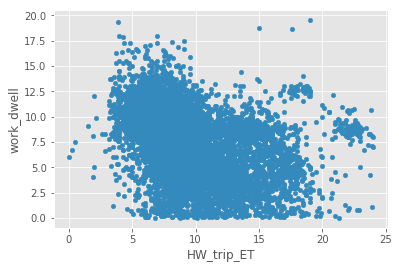

In [3]:
trips.plot.scatter(x='HW_trip_ET',
                   y='work_dwell')

In [4]:
f"Correlation between End Time and Dwell Time: {trips['HW_trip_ET'].corr(trips['work_dwell'])}"

## Given the correlation between HW_trip_ET and work_dwell time
## maybe it makes sense to draw them jointly from a multivariate distribution?

'Correlation between End Time and Dwell Time: -0.4067233807085886'

## "Estimation"

In [5]:
def x_guassian_kde(group, x):
    data = group[[x]].values.T
    return stats.gaussian_kde(data)

def xy_guassian_kde(group, x, y):
    data = group[[x, y]].values.T
    return stats.gaussian_kde(data)



### TOD/HW_trip_ET

In [6]:
# bounds can be manually specified instead
TOD_bounds = (trips.loc[:, ["TOD", "HW_trip_ET"]]
  .groupby("TOD")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
TOD_bounds.columns = TOD_bounds.columns.map('_'.join).str.strip(" _")
#TOD_bounds = TOD_bounds.rename(columns={"TOD_": "TOD"})
TOD_bounds


,HW_trip_ET_min,HW_trip_ET_max
TOD,,
0,3.166667,5.983333
1,6.000000,8.983333
2,9.000000,15.466667
3,15.500000,18.433333
4,0.016667,24.000000


In [7]:
ET_kde = (trips.loc[:, ["TOD", "HW_trip_ET"]]
          #.query("HW_trip_ET==HW_trip_ET") # filtering for NaN
  .groupby("TOD")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="HW_trip_ET")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

ET_kde = ET_kde.join(TOD_bounds, on=["TOD"], lsuffix="_x")
#bounds.columns, ST_kde.columns
ET_kde
# Save ST_kde DataFrame for use in simulation


,kde,HW_trip_ET_min,HW_trip_ET_max
TOD,,,
0,<scipy.stats.kde.gaussian_kde object at 0x7f56...,3.166667,5.983333
1,<scipy.stats.kde.gaussian_kde object at 0x7f56...,6.000000,8.983333
2,<scipy.stats.kde.gaussian_kde object at 0x7f56...,9.000000,15.466667
3,<scipy.stats.kde.gaussian_kde object at 0x7f56...,15.500000,18.433333
4,<scipy.stats.kde.gaussian_kde object at 0x7f56...,0.016667,24.000000


In [8]:
### work_dwell

In [9]:
# bounds can be manually specified instead
WD_bounds = (trips.loc[:, ["dwell_work", "work_dwell"]]
  .groupby("dwell_work")
  .agg(['min', 'max'])
  #.reset_index(inplace=True)
)
WD_bounds.columns = WD_bounds.columns.map('_'.join).str.strip(" _")
#WD_bounds = WD_bounds.rename(columns={"TOD_": "TOD"})
WD_bounds

,work_dwell_min,work_dwell_max
dwell_work,,
1,0.016667,4.500000
2,4.500000,7.750000
3,7.750000,9.000000
4,9.000000,10.483333
5,10.500000,19.500000


In [10]:
#import dfply as dp
#from dfply import >>
#import statsmodels.api as sm

#dens = sm.nonparametric.KDEUnivariate(trips["HW_trip_ET"])
#dens.fit()
#plt.plot(dens.cdf)
#plt.show()



In [11]:
# work_dwell distribution
WD_kde = (trips.loc[:, ["dwell_work", "work_dwell"]]
          #.query("work_dwell==work_dwell") # filtering for NaN
  .groupby("dwell_work")
  .apply(lambda g: pd.Series({"kde": x_guassian_kde(g, x="work_dwell")}))        
  #.apply(ST_guassian_kde)
  #.reset_index(name='kde')
)

WD_kde = WD_kde.join(WD_bounds, on=["dwell_work"], lsuffix="_x")
#bounds.columns, ST_kde.columns
WD_kde
# Save ST_kde DataFrame for use in simulation


,kde,work_dwell_min,work_dwell_max
dwell_work,,,
1,<scipy.stats.kde.gaussian_kde object at 0x7f56...,0.016667,4.500000
2,<scipy.stats.kde.gaussian_kde object at 0x7f56...,4.500000,7.750000
3,<scipy.stats.kde.gaussian_kde object at 0x7f56...,7.750000,9.000000
4,<scipy.stats.kde.gaussian_kde object at 0x7f56...,9.000000,10.483333
5,<scipy.stats.kde.gaussian_kde object at 0x7f56...,10.500000,19.500000


## Simulation

In [12]:
#from urbansim_templates import modelmanager
#modelmanager.initialize()

#modelmanager.register(m)

In [13]:
#ST_kde.loc[1, 'kde'].resample(2)
# In Simulation
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

n_by_TOD = n_by_TOD.join(ET_kde, on="TOD")
         
n_by_TOD["HW_trip_ET"] = n_by_TOD.apply(lambda row: (row['kde'].resample(row['ntrips']))[0, ], axis=1)

#n_by_TOD["HW_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[0, ])
#n_by_TOD["WH_trip_ST"] = n_by_TOD["ST"].apply(lambda x: x[1, ])
#ST_kde.kde.apply(lambda x: x.resample(2))

trips_sim = pd.DataFrame({'TOD':n_by_TOD.TOD.repeat(n_by_TOD.HW_trip_ET.str.len()),
              'HW_trip_ET':np.concatenate(n_by_TOD.HW_trip_ET.values),
              #'WH_trip_ST':np.concatenate(n_by_TOD.WH_trip_ST.values),
             })

#trips_sim = trips_sim.set_index("TOD")
#n_by_TOD.ST.values[0, ][0, ].shape
#n_by_TOD["HW_trip_ST"].apply(lambda x: x.shape)


# To append trips_sim back to trip, sort both trips and trips_sim by TOD
results = (
trips.sort_values(by="TOD")
    .assign(HW_trip_ET_sim=trips_sim.sort_values(by="TOD").loc[:, "HW_trip_ET"].values)
    .loc[:, ["TOD", "HW_trip_ET", "HW_trip_ET_sim"]]
)    

#trips_sim.shape


# handle 24+ hour
#trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

In [14]:
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse(g, obs_col, sim_col):
    r2 = r2_score( g[obs_col], g[sim_col] )
    rmse = np.sqrt( mean_squared_error( g[obs_col], g[sim_col] ) )
    return pd.Series( dict(  r2 = r2, rmse = rmse ) )


In [15]:
def simulate_from_kde(n_by_group, a_kde, group_name, x_name):
    n_by_group = n_by_group.join(a_kde, on=group_name)

    n_by_group[x_name] = n_by_group.apply(lambda row: row['kde'].resample(row['ntrips'])[0, ], axis=1)

    #n_by_group["HW_trip_ST"] = n_by_group["ST"].apply(lambda x: x[0, ])
    #n_by_group["WH_trip_ST"] = n_by_group["ST"].apply(lambda x: x[1, ])
    #a_kde.kde.apply(lambda x: x.resample(2))
    
    group_values = n_by_group[group_name].repeat(n_by_group[x_name].str.len()).values
    x_values = np.concatenate(n_by_group[x_name].values)
    #print(group_values.shape, x_values.shape)
    
    samples = pd.DataFrame({group_name: group_values,
                            x_name: x_values,
                          })
    samples = samples.reset_index()
    #print(samples.index)

    #trips_sim = trips_sim.set_index("TOD")
    #n_by_group.ST.values[0, ][0, ].shape
    #n_by_group["HW_trip_ST"].apply(lambda x: x.shape)

    # handle 24+ hour
    #samples.loc[samples["TOD"].isin([14.0, 24.0]) & (samples.WH_trip_ST < 12), 'WH_trip_ST'] -= 24
    
    samples_w_bounds = samples.join(a_kde, how="left", on=group_name)
    samples_w_bounds.reset_index()
    
    samples_good = (samples_w_bounds.query(f'({x_name}_min <= {x_name} <= {x_name}_max) and ' +
                                           f'({x_name}_min <= {x_name} <= {x_name}_max )')
                                    .loc[:, [group_name, x_name]]
                   )
                         
    _n_by_group = (samples.loc[~samples.index.isin(samples_good.index)]
                        .groupby(group_name)
                        .size()
                        .reset_index(name='ntrips'))
    
    #print(samples.index)
    #print(samples_good.index)
    print("There are {} samples with out of bounds values".format(_n_by_group.ntrips.sum()))
    if _n_by_group.shape[0] > 0:
        samples_extra = simulate_from_kde(_n_by_group, a_kde, group_name, x_name)
        samples = pd.concat([samples_good, samples_extra], sort=False)
            
    return samples


In [16]:
### TOD

In [17]:
n_by_TOD = (trips.groupby("TOD")
  .size()
  .reset_index(name='ntrips')
)

#n_by_TOD.columns, ET_kde.columns
  
trips_sim = simulate_from_kde(n_by_TOD, ET_kde, group_name="TOD", x_name="HW_trip_ET")
#trips_sim.loc[trips_sim.HW_trip_ET > 24, 'HW_trip_ET'] -= 24
#trips_sim.loc[trips_sim["TOD"].isin([14.0, 24.0]) & (trips_sim.WH_trip_ST < 12), 'WH_trip_ST'] -= 24

There are 1012 samples with out of bounds values
There are 85 samples with out of bounds values
There are 10 samples with out of bounds values
There are 0 samples with out of bounds values


In [18]:
assert np.alltrue( 
    n_by_TOD == (trips_sim.groupby("TOD")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [19]:
# check for samples out of bounds; should be empty
(
trips_sim.join(TOD_bounds, on="TOD")
    .query('(HW_trip_ET < HW_trip_ET_min) or ' +
                '(HW_trip_ET > HW_trip_ET_max)')
)

,TOD,HW_trip_ET,index,HW_trip_ET_min,HW_trip_ET_max


In [20]:
# validation
results = (
trips.sort_values(by="TOD")
    .assign(HW_trip_ET_sim=trips_sim.sort_values(by="TOD").loc[:, "HW_trip_ET"].values)
    .loc[:, ["TOD", "HW_trip_ET", "HW_trip_ET"]]
)    

results.groupby('TOD').apply( r2_rmse, 
                            obs_col = "HW_trip_ET", 
                            sim_col = "HW_trip_ET" ).reset_index()

,TOD,r2,rmse
0,0,1.0,0.0
1,1,1.0,0.0
2,2,1.0,0.0
3,3,1.0,0.0
4,4,1.0,0.0


### work_dwell

In [21]:
n_by_WD = (trips.groupby("dwell_work")
  .size()
  .reset_index(name='ntrips')
)

#n_by_DT.columns, DT_kde.columns
  
trips_sim = simulate_from_kde(n_by_WD, WD_kde, group_name="dwell_work", x_name="work_dwell")


There are 1111 samples with out of bounds values
There are 86 samples with out of bounds values
There are 7 samples with out of bounds values
There are 0 samples with out of bounds values


In [22]:
assert np.alltrue( 
    n_by_WD == (trips_sim.groupby("dwell_work")
                 .size()
                 .reset_index(name='ntrips')
                )
)
#trips_sim.columns, bounds.columns

In [23]:
# check for samples out of bounds; should be empty
(
trips_sim.join(WD_bounds, on="dwell_work")
    .query('(work_dwell < work_dwell_min) or ' +
                '(work_dwell > work_dwell_max)')
)

,dwell_work,work_dwell,index,work_dwell_min,work_dwell_max


In [24]:
# validation
results = (
trips.sort_values(by="dwell_work")
    .assign(work_dwell_sim=trips_sim.sort_values(by="dwell_work").loc[:, "work_dwell"].values)
    .loc[:, ["dwell_work", "work_dwell", "work_dwell_sim"]]
)    

results.groupby('dwell_work').apply( r2_rmse, 
                                    obs_col = "work_dwell", 
                                    sim_col = "work_dwell_sim" ).reset_index()

,dwell_work,r2,rmse
0,1,-0.962118,1.787003
1,2,-0.921704,1.311009
2,3,-0.962368,0.455472
3,4,-0.931290,0.573534
4,5,-0.971429,1.766805


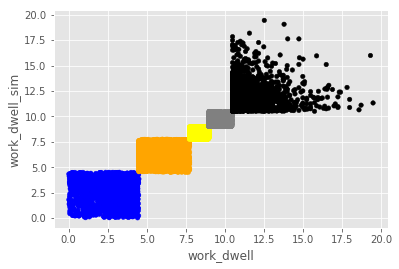

In [26]:
colors = {0:'violet', 1:'blue', 
          2:'orange', 3:'yellow',
          4:'grey', 5: 'black'
         }

results.plot.scatter(x='work_dwell',
                     y='work_dwell_sim',
                     c=results.dwell_work.apply(lambda x: colors[x]))